# Policy Gradient with Pong

여기서는 Pong게임을 플레이하는 뉴럴넷을 PG를 사용하여 학습해본다.

* GPU를 하나만 가져오자

In [12]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

* env를 만들고,
* matplotlib을 이용해서 rendering을 할 수 있도록 한다.

In [13]:
import numpy as np
import gym
import matplotlib.pyplot as plt
# jupyter에서 많은 기능을 쓸 수 있게 해준다네..
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation

In [14]:
env = gym.make("Pong-v0")
observation = env.reset()
print(env.observation_space)
print(env.action_space)  # 신기한게, action이 6개나 되네?? 방향키4개 + A/B 버튼인가...

[2017-07-10 21:02:38,001] Making new env: Pong-v0


Box(210, 160, 3)
Discrete(6)


<IPython.core.display.Javascript object>


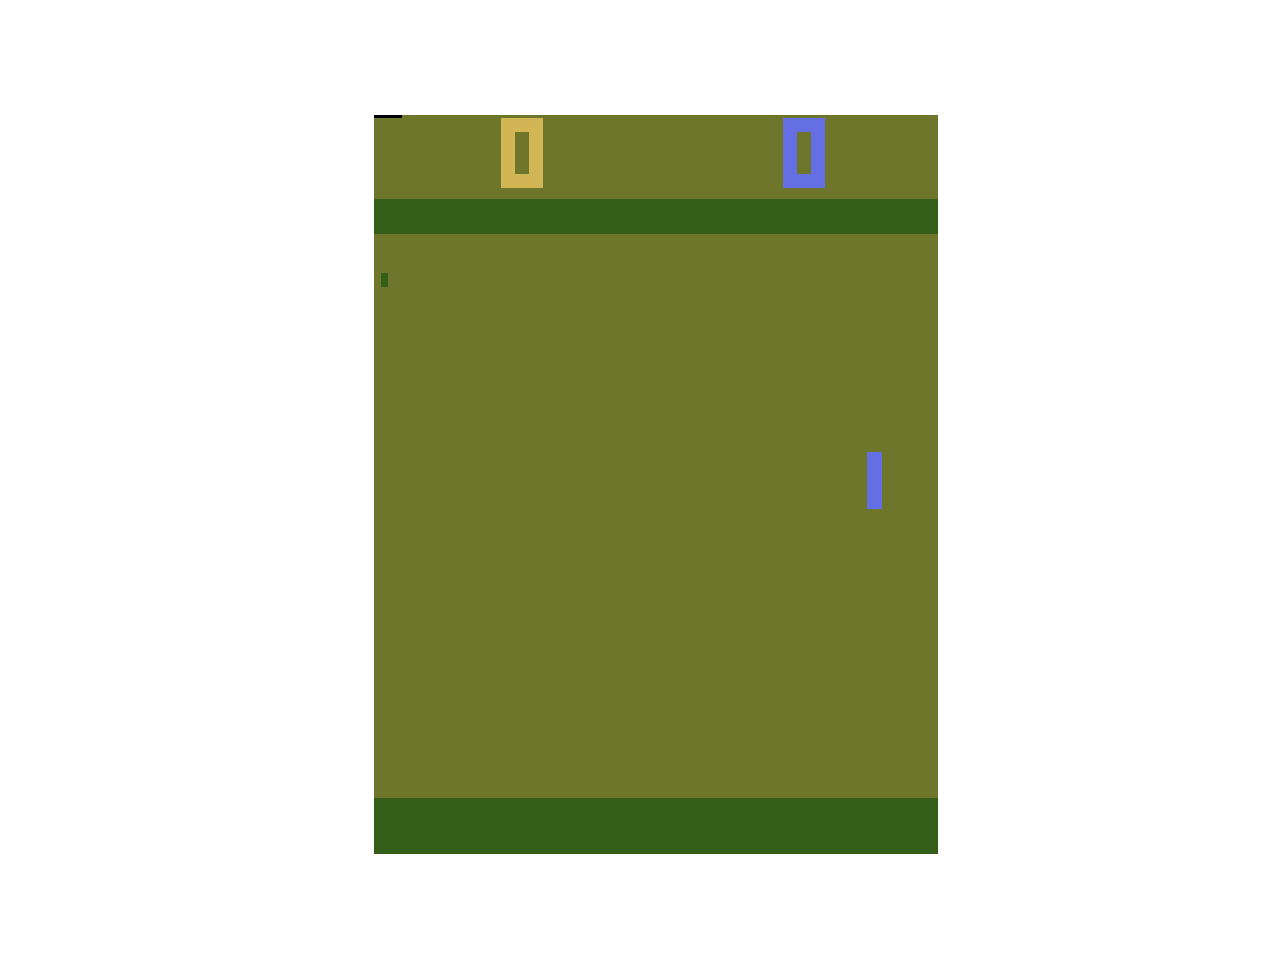

In [15]:
render = lambda : plt.imshow(env.render(mode='rgb_array')); plt.axis('off')
render()

## 게임을 한번 해보자.

밑에 action을 2,3으로 주면서 실험해보면 up:2, down:3임을 알 수 있다.

[2017-07-10 21:02:43,101] Making new env: Pong-v0


<IPython.core.display.Javascript object>


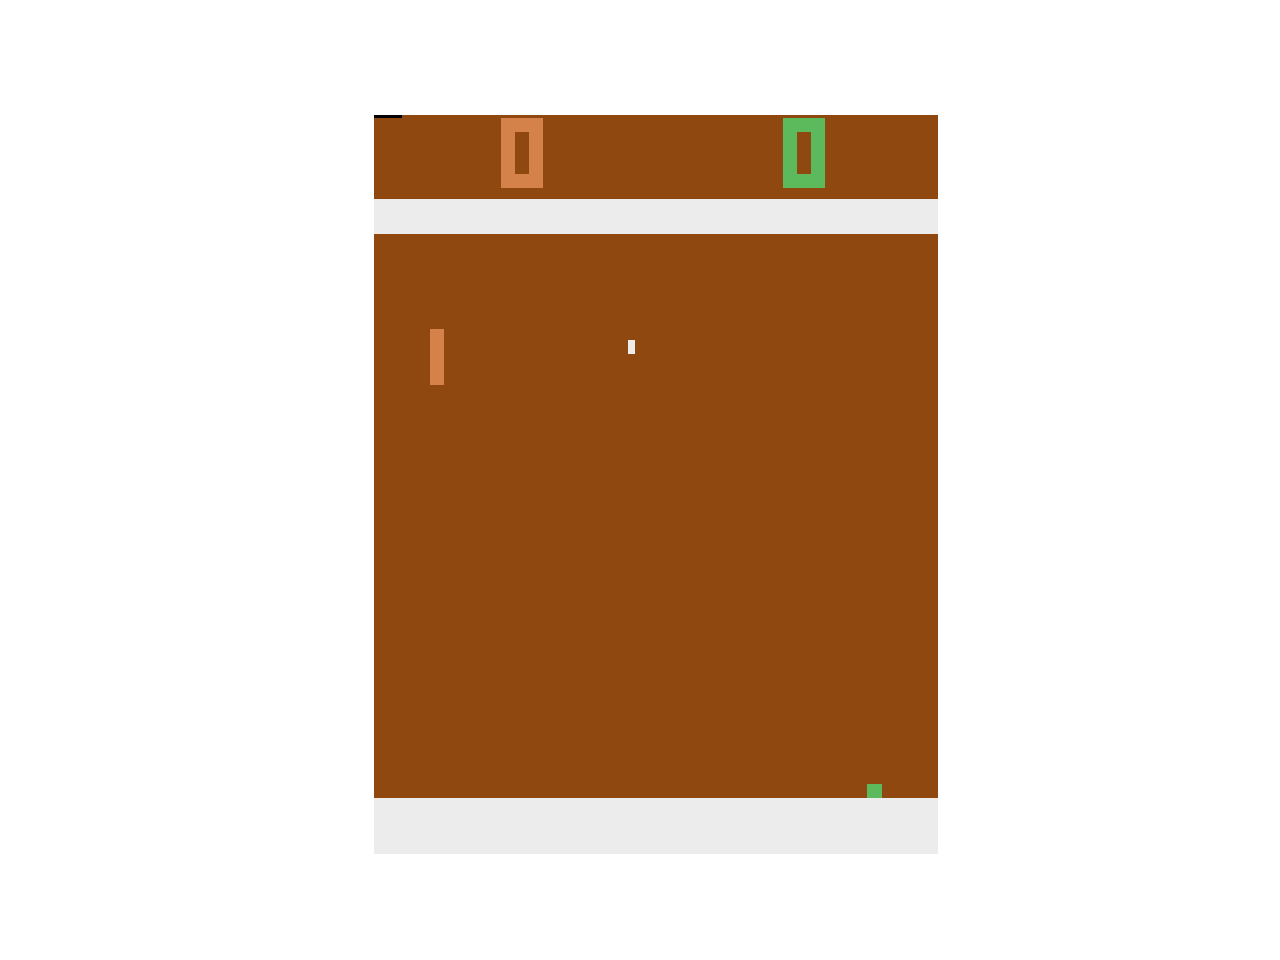

In [16]:
from matplotlib import animation, rc

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return (patch,)

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig,
                                   update_scene,
                                   fargs=(frames, patch),
                                   frames=len(frames),
                                   repeat=repeat,
                                   interval=interval)

frames = []

env = gym.make("Pong-v0")
observation = env.reset()

for step in range(100):
    img = env.render(mode='rgb_array')
    frames.append(img)

    prob = np.random.uniform(0, 1)
    if prob > 0.5:
        action = 2  # up
    else:
        action = 3  # down

    obs, reward, done, info = env.step(action)
    if done:
        break
video = plot_animation(frames)


* prepro는 게임 화면에서, 배경색을 제외한 object들만 가져와서 실제 네트워크에 넣을 input을 만들 녀석이다.

> 나중에 보면 알겠지만 사실 diff를 해서 넣게된다.

In [17]:
img = env.render(mode='rgb_array')
print(img.shape)

(210, 160, 3)


<IPython.core.display.Javascript object>


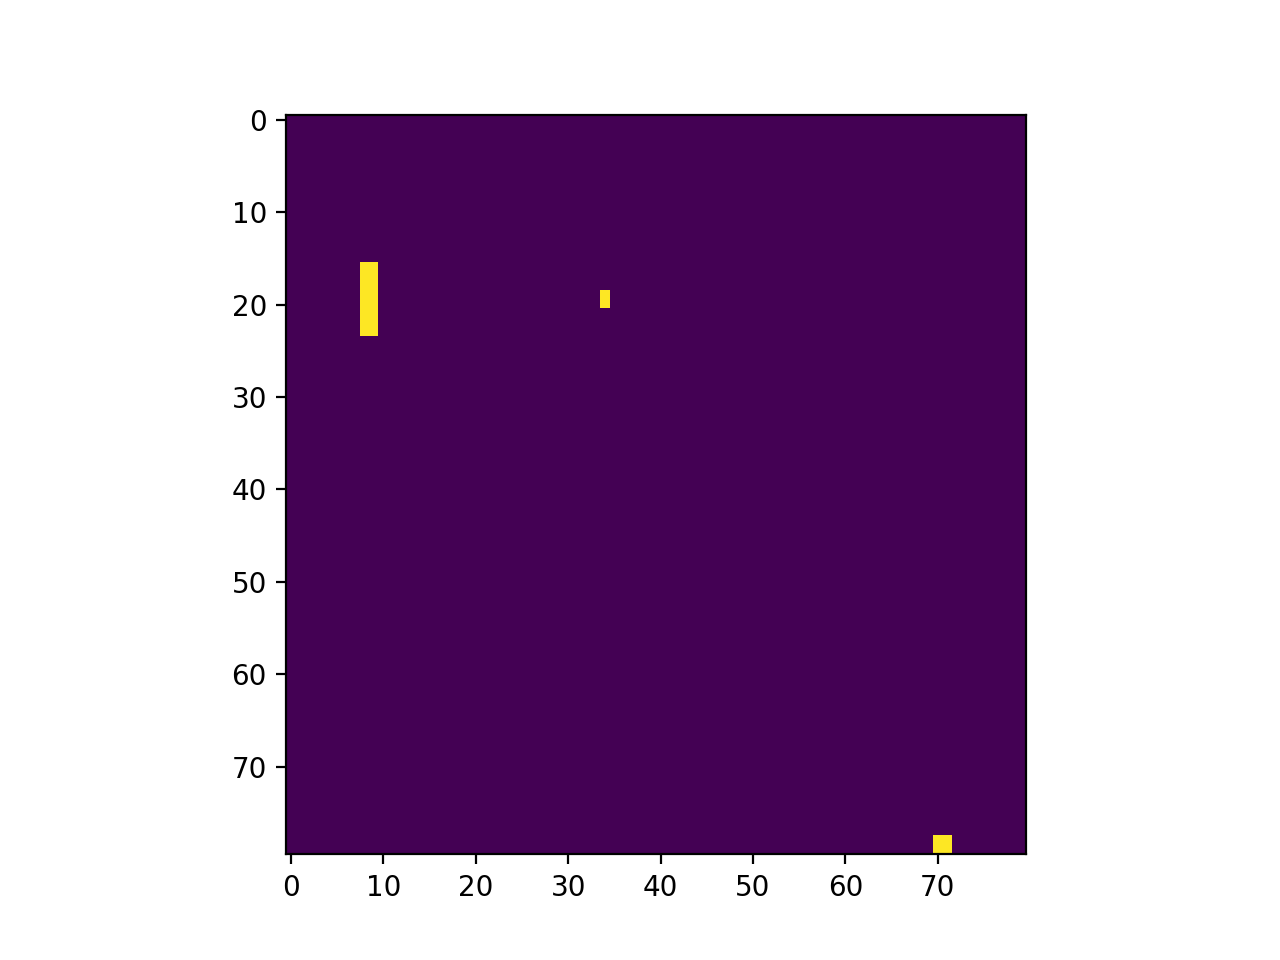

shape of input: (80, 80)


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [18]:
def prepro(I, show=False):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # 실제 플레이 화면만 crop해온다. (위의 진한 녹색 사이의 부분)
    I = I[::2,::2,0] # 1/2로 downsample
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    if show:
        plt.close()
        plt.imshow(I)
        print("shape of input: {}".format(I.shape))
    return I.astype(np.float).ravel()

prepro(img, show=True)

* Hyperparameter 정의
* Network 만들기

In [19]:
import tensorflow as tf

tf.reset_default_graph()

# hyperparameters
H = 200 # Hidden size
batch_size = 1 # 한번에 돌릴 env 갯수
learning_rate = 1e-3
decay_rate = 0.99 # decay factor for RMSProp
# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid

###### Model ######

net_inputs = tf.placeholder(shape=[None, D], dtype=tf.float32)

W1 = tf.contrib.layers.fully_connected(net_inputs, H)
logits = tf.contrib.layers.fully_connected(W1, 1)
outputs = tf.nn.sigmoid(logits)

# 0: up을 할 확률, 1: down을 할 확률
p_up = tf.concat(axis=1, values=[outputs, 1 - outputs])
# 샘플을 한다.
action = tf.multinomial(tf.log(p_up), num_samples=1)

# action이 0이면 이녀석의 확률을 높여주어야 하지...
y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

optimizer = tf.train.AdamOptimizer(learning_rate)
# gradient의 크기와, variable이 나온다.
grads_and_vars = optimizer.compute_gradients(cross_entropy)

# gradient만 뽑아내야지.. reward랑 곱해서 다시 들어가야함
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []

# gradient의 크기를 받아서 apply하는 부분!
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


In [20]:
def discount_rewards(rewards, discount_rate):
    '''
    미래의 reward를 계산해서 전체 reward를 update한다.
    맨 마지막 step서부터 discount를 하고 더하면서 들어간다.
    '''
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    '''
    모든 reward sequence마다 discount_rewards를 호출하고 mean, std로 normalize한다.
    '''
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) 
                                  for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std 
                for discounted_rewards in all_discounted_rewards]

print(discount_rewards([10, 0, -50], discount_rate=0.8))
print(discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8))

[-22. -40. -50.]
[array([-0.28435071, -0.86597718, -1.18910299]), array([ 1.26665318,  1.0727777 ])]


In [21]:
gamma = 0.99 # discount factor for reward
env = gym.make("Pong-v0")
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    init.run()
    for iteration in range(11):  # iteration은 1000번!
        all_rewards = []
        all_gradients = []
        
        for game in range(10):  # 10 게임을 한번에 볼 것이다.
            current_rewards = []
            current_gradients = []
            
            observation = env.reset()
            prev_inputs = None
            
            for step in range(100):  # 한 게임당 100 step을 돌 것이다.
                # preprocessing input
                cur_inputs = [prepro(observation)]
                cur_inputs = np.stack(cur_inputs, axis=0)
                
                if prev_inputs is None:
                    inputs = np.zeros_like(cur_inputs)
                else:
                    inputs = cur_inputs - prev_inputs
                prev_inputs = cur_inputs
                
                # NN에서 현재 input에 대한 action과 gradient를 가져온다.
                action_val, grad_val = sess.run([action, gradients],
                                                feed_dict={net_inputs: inputs})
                # action을 수행하고 reward등의 정보를 얻는다.
                observation, reward, done, info = env.step(action_val[0][0]+2)  # 2, 3이 우리가 control할 것이지...
                
                current_rewards.append(reward)
                current_gradients.append(grad_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            env.close()
        # 모든 reward seq에 대해 discount를 하고 normalize함
        all_rewards = discount_and_normalize_rewards(all_rewards,
                                                     discount_rate=gamma)
        feed_dict = {}
        # 각 session에 discounted reward를 곱한다.
        for var_idx, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_idx]
                                         for game_index, rewards in enumerate(all_rewards)
                                             for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        
        if iteration % 10 == 0:
            print(iteration)
            saver.save(sess, "./testPong.ckpt")

    

[2017-07-10 21:03:00,555] Making new env: Pong-v0


0
10


INFO:tensorflow:Restoring parameters from ./testPong.ckpt


[2017-07-10 21:05:24,136] Restoring parameters from ./testPong.ckpt
[2017-07-10 21:05:24,172] Making new env: Pong-v0


1242


<IPython.core.display.Javascript object>


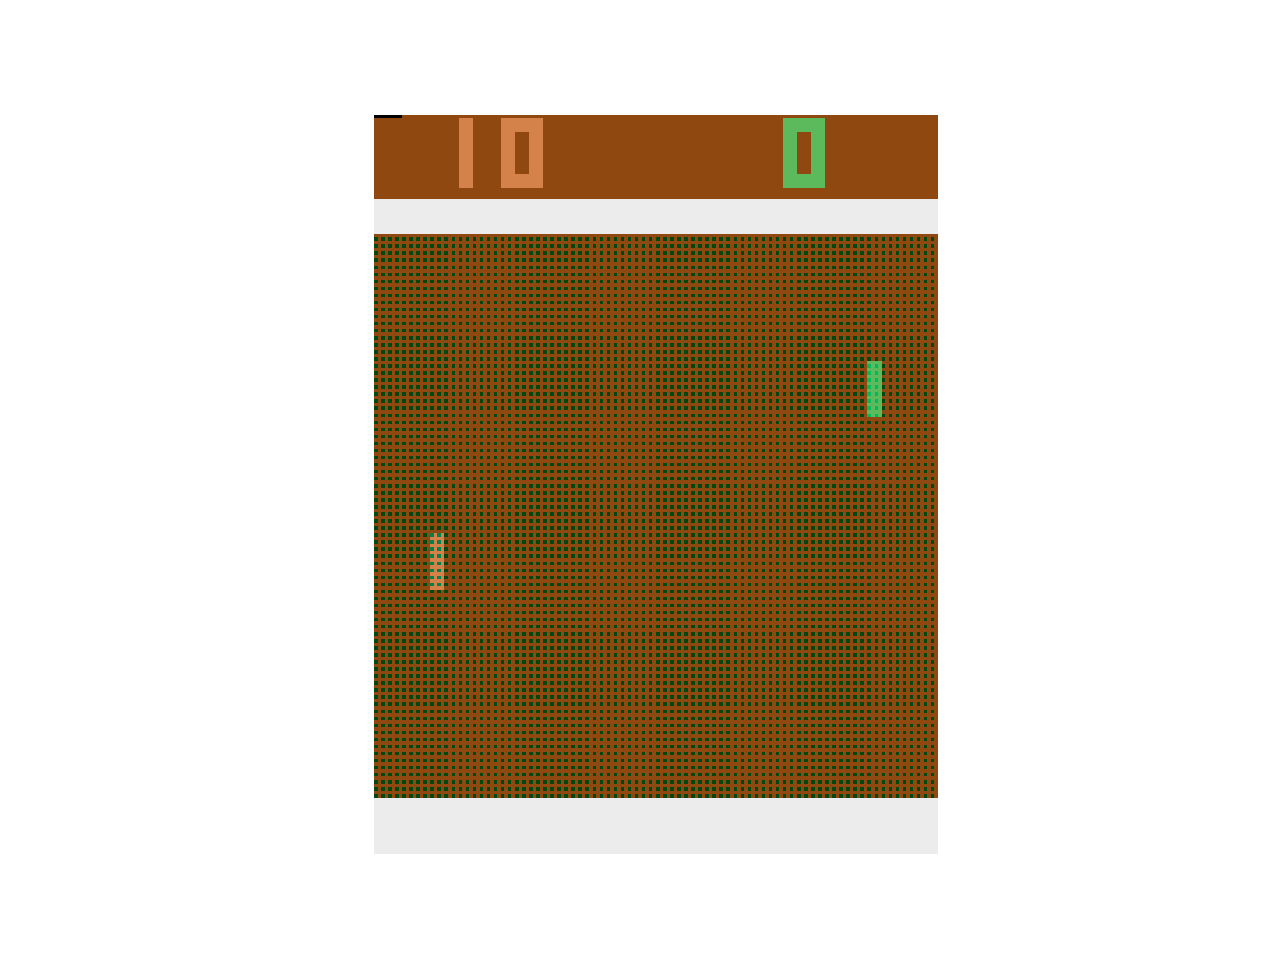

In [22]:
gamma = 0.99 # discount factor for reward

frames = []
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    saver.restore(sess, "./testPong.ckpt")
    env = gym.make("Pong-v0")
    observation = env.reset()
    prev_inputs = None

    for step in range(10000):  # 한 게임당 10000 step을 돌 것이다.
        frames.append(observation)
        # preprocessing input
        cur_inputs = [prepro(observation)]
        cur_inputs = np.stack(cur_inputs, axis=0)

        if prev_inputs is None:
            inputs = np.zeros_like(cur_inputs)
        else:
            inputs = cur_inputs - prev_inputs
        prev_inputs = cur_inputs

        # NN에서 현재 input에 대한 action과 gradient를 가져온다.
        action_val = sess.run([action],
                              feed_dict={net_inputs: inputs})
        # action을 수행하고 reward등의 정보를 얻는다.
        observation, reward, done, info = env.step(action_val[0][0]+2)

        if done:
            break
print(len(frames))
video = plot_animation(frames)

# BackUp
---

In [ ]:
gamma = 0.99 # discount factor for reward
batch_size = 10

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    init.run()
    for iteration in range(1000):  # iteration은 1000번!
        all_rewards = []
        all_gradients = []
        
        for game in range(10):  # 10게임을 한번에 볼 것이다.
            current_rewards = []
            current_gradients = []
            
            env = gym.make("Pong-v0")
            observation = env.reset()
            prev_inputs = None
            
            for step in range(1000):  # 한 게임당 1000 step을 돌 것이다.
                # preprocessing input
                cur_inputs = [prepro(observation)]
                cur_inputs = np.stack(cur_inputs, axis=0)
                
                if prev_inputs is None:
                    inputs = np.zeros_like(cur_inputs)
                else:
                    inputs = cur_inputs - prev_inputs
                prev_inputs = cur_inputs
                
                # NN에서 현재 input에 대한 action과 gradient를 가져온다.
                action_val, grad_val = sess.run([action, gradients],
                                                feed_dict={net_inputs: inputs})
                # action을 수행하고 reward등의 정보를 얻는다.
                observation, reward, done, info = env.step(action_val[0][0])
                
                current_rewards.append(reward)
                current_gradients.append(grad_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            env.close()
        # 모든 reward seq에 대해 discount를 하고 normalize함
        all_rewards = discount_and_normalize_rewards(all_rewards,
                                                     discount_rate=gamma)
        feed_dict = {}
        for var_idx, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_idx]
                                         for game_index, rewards in enumerate(all_rewards)
                                             for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        
        if iteration % 1000 == 0:
            saver.save(sess, "./testPong.ckpt")

    